In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper

In [4]:
#Import Plots
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')


In [5]:
#Import plot colors
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }


In [6]:
#Import Forecasting Libraries
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

In [21]:
#Import Data from CmcScraper
scraper = CmcScraper('BTC', '28-04-2013', '01-01-2022')

In [22]:
#Imported data into a DataFrame
data = scraper.get_dataframe()

In [23]:
#Cleaning the DataFrame
data.sort_values(by='Date', ascending=True, inplace=True)

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
display(data)

,Date,Open,High,Low,Close,Volume,Market Cap
3170,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3169,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3168,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3167,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3166,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2021-12-28,50679.859377,50679.859377,47414.209925,47588.854777,3.343038e+10,9.000762e+11
3,2021-12-29,47623.870463,48119.740950,46201.494371,46444.710491,3.004923e+10,8.784788e+11
2,2021-12-30,46490.606049,47879.965500,46060.313166,47178.125843,2.668649e+10,8.923863e+11
1,2021-12-31,47169.372859,48472.527490,45819.954553,46306.446123,3.697417e+10,8.759394e+11


In [26]:
pd.reset_option('display.max_columns')

In [27]:
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')

In [28]:
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [29]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [31]:
# Dict with Bitcoin halvings info
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [32]:
# Next halving calculation
# The remaining blocks according to the coinmarketcap.com website for 
# the next halving as of 2022-01-14 are taken as a starting point
remaining_blocks = 121400
blocks_per_day = 144

days = remaining_blocks / blocks_per_day

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=days)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'The next halving will occur on approximately: {next_halving}')

The next halving will occur on approximately: 2024-05-06


In [33]:
# Include rewards and countdown to next halving in dataset
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Start and end date of each halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Fill column 'reward' with mining rewards
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Fill column 'countdown_halving' with remaining days
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [34]:
# Check that the data have been created correctly
print('Second halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Third halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Next halving:', btc_halving['date'][4])
data.tail(2)

Second halving: 2016-07-09


,open,close,high,low,reward,countdown_halving
date,,,,,,
2016-07-08,640.687988,666.523010,666.706970,636.466980,25.0,0.0
2016-07-09,666.383972,650.960022,666.383972,633.398987,12.5,1401.0



Third halving: 2020-05-11


,open,close,high,low,reward,countdown_halving
date,,,,,,
2020-05-10,9591.169231,8756.431142,9595.580629,8395.107451,12.50,0.0
2020-05-11,8755.535639,8601.796202,9033.471176,8374.322975,6.25,1455.0



Next halving: 2024-05-06


,open,close,high,low,reward,countdown_halving
date,,,,,,
2021-12-31,47169.372859,46306.446123,48472.527490,45819.954553,6.25,856.0
2022-01-01,46311.744663,47686.811509,47827.310995,46288.486095,6.25,855.0


In [36]:
# Selection of train-test dates
start_train = '2020-01-01 00:00:00'
end_train = '2021-06-30 23:59:59'

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")

Complete time series : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00  (n=3171)
Train dates          : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Test dates           : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00  (n=185)


In [37]:
# Random walk simulation

df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Test error
y_true = df_rw.loc[end_train:, 'close']
y_pred = df_rw.loc[end_train:, 'pred_close']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].head(4))

Test error: 1267.7978352283603


,close,pred_close
date,,
2021-07-01,33572.117653,35040.837249
2021-07-02,33897.048590,33572.117653
2021-07-03,34668.548402,33897.048590
2021-07-04,35287.779766,34668.548402


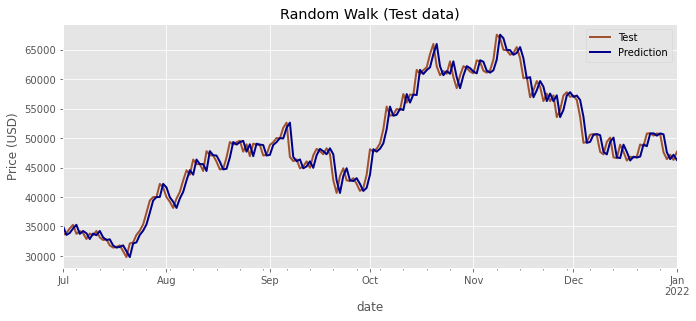

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test',
                                    c='sienna')
df_rw.loc[end_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Prediction',
                                    c='darkblue')
ax.set_title('Random Walk (Test data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [39]:
# DataFrame models' test error
df_errors = pd.DataFrame({'model': 'Base - Random Walk', 'lags': 1, 
                          'test_error': metric, 'exog_variables': False},
                         index=[0])
df_errors

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1267.797835,False


In [40]:
# Change of the categorical variables to category type
data['month'] = data.index.month
data['month'] = data['month'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'month'])
data.head(2)

,open,close,high,low,countdown_halving,reward_6.25,reward_12.5,reward_25.0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,1167.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.444000,144.539993,147.488007,134.000000,1166.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [42]:
# All exogenous variables are selected, including those obtained during one hot encoding.
exog = [column for column in data.columns if column.startswith(('reward', 'month'))]
exog.extend(['countdown_halving'])
print(exog)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'countdown_halving']


In [81]:
# Forecaster backtest with exogenous variables

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = 1
                )

# Backtest test data, 1 step
metric, predictions = backtesting_forecaster(
                             forecaster = forecaster,
                             y          = data.loc[start_train:, 'close'],
                             exog       = data.loc[start_train:, exog],
                             initial_train_size = len(data.loc[start_train:end_train, 'close']),
                             fixed_train_size   = True,
                             steps      = 1,
                             refit      = True,
                             metric     = 'mean_absolute_error',
                             verbose    = False
                             )

Forecaster will be fit 185 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



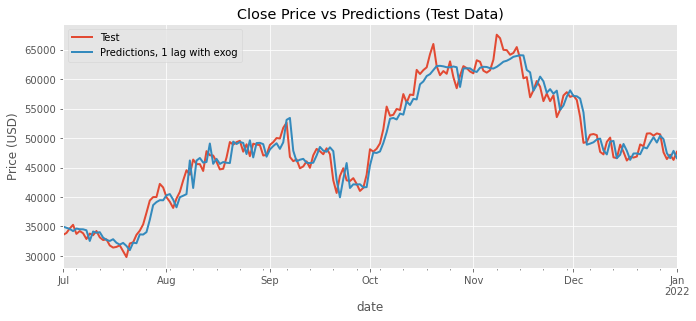

In [101]:
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')
# Plot predictions 1 lag with exogenous variables
predictions_exog = predictions.rename(columns={'pred': f'Predictions, 1 lag with exog'})
predictions_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [ ]:
#L1 Regression

In [97]:
test2 = data.loc[end_train:, 'close'].values.reshape(-1, 1)

In [98]:
pred2 = predictions_exog.values.reshape(-1, 1)

In [72]:
from sklearn import linear_model as lm

In [73]:
lasso_reg = lm.Lasso(alpha=100, max_iter=100,tol=0.1)

In [99]:
lasso_reg.fit(test2, pred2)

Lasso(alpha=100, max_iter=100, tol=0.1)

In [100]:
lasso_reg.score(test2, pred2)

0.957420832934658